In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from google.colab import drive

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Загрузка и первичный осмотр данных

In [84]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [85]:
df_train = pd.read_csv('/content/drive/MyDrive/1T_sprint_titanic/train.csv')


In [86]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [87]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [88]:
df_train.isna().mean()

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

# Предобработка на скорую руку

Видим, что в столбце Cabin очень много пропусков, больше 77 %. Удалим этот столбец. Также удалим столбцы PassengerId, Name, Ticket тк они не несут смысловой нагрузки. Остальные столбцы пока оставим. 

## Удаление избыточных признаков

In [89]:
df_train = df_train.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
df_train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [90]:
df_train = df_train[df_train['Embarked'].isna() == False]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.5+ KB


Остались пропуски в столбце возраста. И пропусков довольно много. Попробуем что-то с этим сделать. 

## Корреляция

Посмотрим матрицу корреляции между признаками.

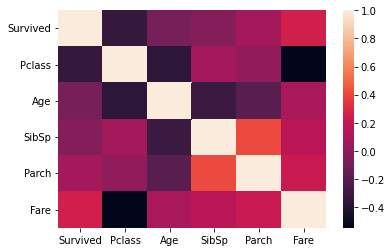

In [91]:
corr = df_train.corr() 
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values) 
plt.show()

Зависимости  между данными не найдено. 

Посмотрим распределение возрастов. 

## Пропуски в AGE

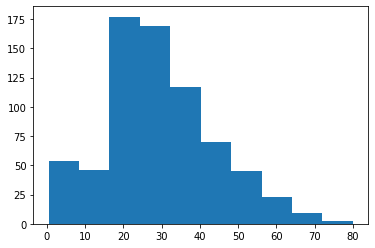

In [92]:
plt.hist(df_train['Age'])
plt.show()

Заменим пропуски в столбце Age на 100.

In [93]:
df_train["Age"] = df_train["Age"].fillna(100)

In [94]:
df_train["Age"] = df_train['Age'].transform(lambda x: x.round()).astype('int16')

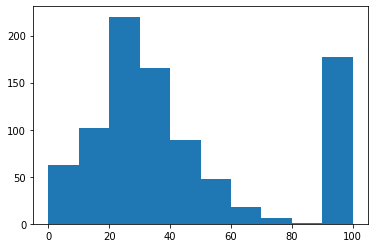

In [95]:
plt.hist(df_train['Age'])
plt.show()

In [96]:
'''df_train["M_Age"] = np.where(
     df_train["Age"].between(0, 20, inclusive=False),
    10,
    np.where(
     df_train["Age"].between(20, 30, inclusive=False),
    25,
    np.where(
     df_train["Age"].between(30, 40, inclusive=False),
    35,
     np.where(
        df_train["Age"].between(40, 50, inclusive=False), 
    45, 
    np.where(
        df_train["Age"].between(50, 60, inclusive=False), 
    55, 
    np.where(
        df_train["Age"].between(60, 70, inclusive=False), 
    65, 
    np.where(
        df_train["Age"].between(70, 80, inclusive=False), 
    75, 80

     ) ) ) ) ) )
) '''

'df_train["M_Age"] = np.where(\n     df_train["Age"].between(0, 20, inclusive=False),\n    10,\n    np.where(\n     df_train["Age"].between(20, 30, inclusive=False),\n    25,\n    np.where(\n     df_train["Age"].between(30, 40, inclusive=False),\n    35,\n     np.where(\n        df_train["Age"].between(40, 50, inclusive=False), \n    45, \n    np.where(\n        df_train["Age"].between(50, 60, inclusive=False), \n    55, \n    np.where(\n        df_train["Age"].between(60, 70, inclusive=False), \n    65, \n    np.where(\n        df_train["Age"].between(70, 80, inclusive=False), \n    75, 80\n\n     ) ) ) ) ) )\n) '

In [97]:
df_train = df_train[df_train['Age'].isna() == False]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    int16  
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(1), int16(1), int64(4), object(2)
memory usage: 57.3+ KB


## Ящики с усами по числовым признакам

Построим ящики с усами для количественных признаков

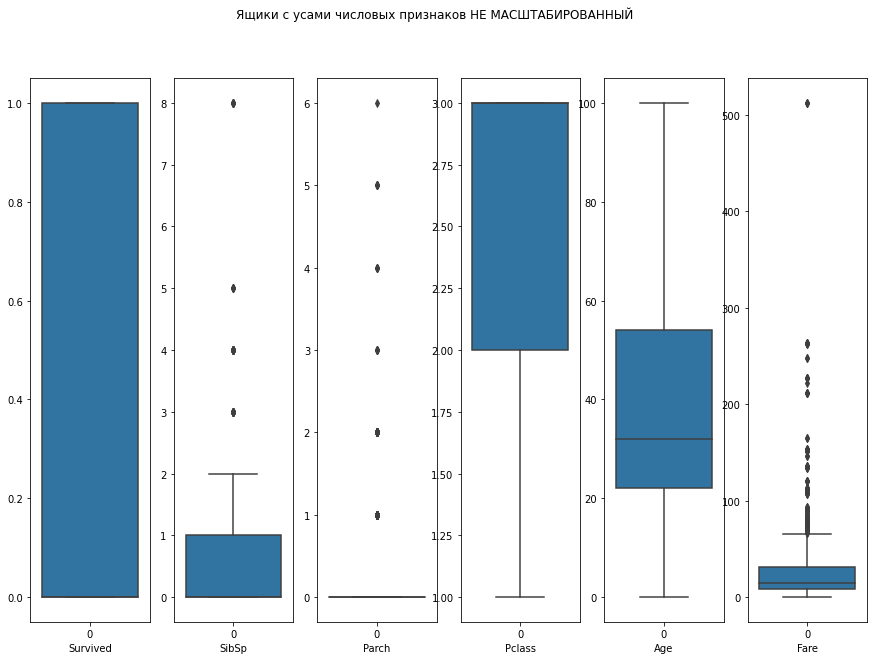

In [98]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(15,10)) #, sharey=True)
sns.boxplot(data=df_train['Survived'],  ax=ax1) 
sns.boxplot(data=df_train['SibSp'], ax=ax2) 
sns.boxplot(data=df_train['Parch'], ax=ax3) 
sns.boxplot(data=df_train['Pclass'], ax=ax4)  
sns.boxplot(data=df_train['Age'], ax=ax5) 
sns.boxplot(data=df_train['Fare'], ax=ax6) 


ax1.set_xlabel('Survived'), ax1.set_ylabel('')
ax2.set_xlabel('SibSp'), ax2.set_ylabel('')
ax3.set_xlabel('Parch'), ax3.set_ylabel('')
ax4.set_xlabel('Pclass'), ax4.set_ylabel('')
ax5.set_xlabel('Age'), ax5.set_ylabel('')
ax6.set_xlabel('Fare'), ax6.set_ylabel('')

plt.suptitle('Ящики с усами числовых признаков НЕ МАСШТАБИРОВАННЫЙ')
plt.show()

In [99]:
col_cols = set(df_train.columns) - set(['Sex', 'Embarked'])
cat_cols = set(df_train.columns) - set(col_cols)

Посмотрим на выбросы. Насколько они адекватны. 

SibSp — это число братьев, сестер или супругов на борту у человека.

In [100]:
df_train['SibSp'].value_counts()

0    606
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

Хорошо, цифры вполне реальны. Оставим как есть. 

Parch - это количество родителей / детей на борту.

In [101]:
df_train['Parch'].value_counts()

0    676
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

Ок, тоже оставим как есть.

Посмотрим на плату за проезд.

In [102]:
df_train[df_train['Fare'] > 200]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
27,0,1,male,19,3,2,263.0000,S
88,1,1,female,23,3,2,263.0000,S
118,0,1,male,24,0,1,247.5208,C
258,1,1,female,35,0,0,512.3292,C
299,1,1,female,50,0,1,247.5208,C
311,1,1,female,18,2,2,262.3750,C
341,1,1,female,24,3,2,263.0000,S
377,0,1,male,27,0,2,211.5000,C
380,1,1,female,42,0,0,227.5250,C
438,0,1,male,64,1,4,263.0000,S


Допустим, что кто-то платил очень много. Все это пассажиры первого класса, так что пусть останется все как есть. 

## Гистограммы категориальных признаков

Построим гистограммы категориальных признаков.

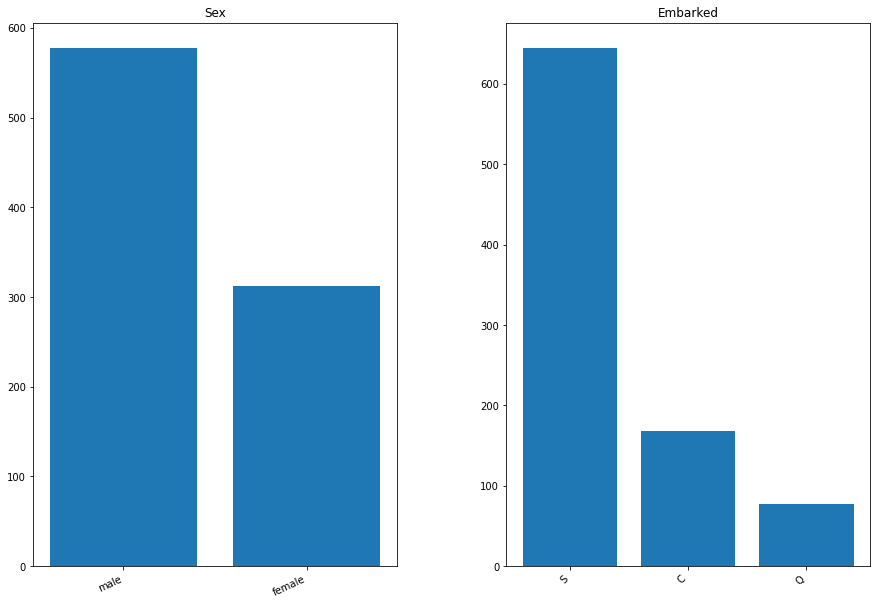

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))

ax = ax.ravel()
j = 0
for i in cat_cols:
    
    ax[j].set_title(f'{i}')
    ax[j].bar(x = df_train[i].value_counts().index, height = df_train[i].value_counts().values)
                  
    labels = ax[j].get_xticklabels()
    plt.setp(labels, rotation = 25, horizontalalignment = 'right')
    plt.xticks(rotation=45) 
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    j +=1
    
fig.show()

## Удаление дубликатов

In [104]:
df_train= df_train.drop_duplicates()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  775 non-null    int64  
 1   Pclass    775 non-null    int64  
 2   Sex       775 non-null    object 
 3   Age       775 non-null    int16  
 4   SibSp     775 non-null    int64  
 5   Parch     775 non-null    int64  
 6   Fare      775 non-null    float64
 7   Embarked  775 non-null    object 
dtypes: float64(1), int16(1), int64(4), object(2)
memory usage: 50.0+ KB


## Распределение целевого признака

Посмотрим на распределение целевого признака. 

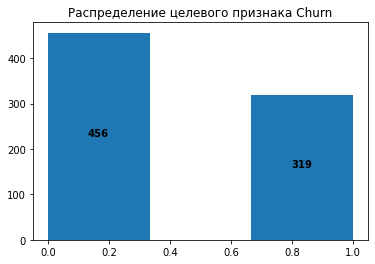

In [105]:
plt.hist(df_train['Survived'], bins = 3)
plt.title('Распределение целевого признака Churn')
plt.text(0.13, df_train['Survived'].value_counts()[0]/2, df_train['Survived'].value_counts()[0], color='black', fontweight='bold')
plt.text(0.80, df_train['Survived'].value_counts()[1]/2, df_train['Survived'].value_counts()[1], color='black', fontweight='bold')
plt.show()

Видим, что классы более менее сбалансированы.

## Кодирование категориальных признаков

Произведем кодирование категориальных признаков. Для CatBoost не будем производить кодирование, тк там оно встроено, поэтому создадим копию датасета. 

In [106]:
df_catboost = df_train.copy()
df_catboost.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22,1,0,7.2500,S
1,1,1,female,38,1,0,71.2833,C
2,1,3,female,26,0,0,7.9250,S
3,1,1,female,35,1,0,53.1000,S
4,0,3,male,35,0,0,8.0500,S


In [107]:
df_train = pd.get_dummies(df_train,drop_first=True)
df_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,22,1,0,7.2500,1,0,1
1,1,1,38,1,0,71.2833,0,0,0
2,1,3,26,0,0,7.9250,0,0,1
3,1,1,35,1,0,53.1000,0,0,1
4,0,3,35,0,0,8.0500,1,0,1


## Вывод

Вывод:
Была проведена небольшая преобработка данных, а именно:
1. удаление избыточных признаков, 
2. удаление некоторых строк с пропусками, 
3. замена пропусков у признака возраст на значение 100, 
4. изменение типов данных,
5. удаление дубликатов,
6. кодирование категориальных признаков.

# Разделение на выборки

## Разделение на train и valid

In [108]:
X = df_train.drop(columns = ['Survived'])
y = df_train['Survived']

In [109]:
X_catboost = df_catboost.drop(columns = ['Survived'])
y_catboost = df_catboost['Survived']

In [110]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 775 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      775 non-null    int64  
 1   Age         775 non-null    int16  
 2   SibSp       775 non-null    int64  
 3   Parch       775 non-null    int64  
 4   Fare        775 non-null    float64
 5   Sex_male    775 non-null    uint8  
 6   Embarked_Q  775 non-null    uint8  
 7   Embarked_S  775 non-null    uint8  
dtypes: float64(1), int16(1), int64(3), uint8(3)
memory usage: 34.1 KB


In [111]:
X_train, X_valid, y_train, y_valid= train_test_split(X, y, test_size=0.20, random_state=111222, stratify=y)

In [112]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat= train_test_split(X_catboost, y_catboost, test_size=0.20, random_state=111222, stratify=y)

In [113]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((620, 8), (155, 8), (620,), (155,))

In [114]:
y_train.mean(), y_valid.mean()

(0.4112903225806452, 0.4129032258064516)

In [115]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
465,3,38,0,0,7.0500,1,0,1
195,1,58,0,0,146.5208,0,0,0
479,3,2,0,1,12.2875,0,0,1
720,2,6,0,1,33.0000,0,0,1
651,2,18,0,1,23.0000,0,0,1


## Взаимная корреляция с помощью коэффициента Phik

Посмотрим взаимную корреляцию признаков с помощью коэффициента Phik.

In [116]:
interval_cols = ['Age', 'Fare']
phik_overview = X_train.phik_matrix(interval_cols=interval_cols)

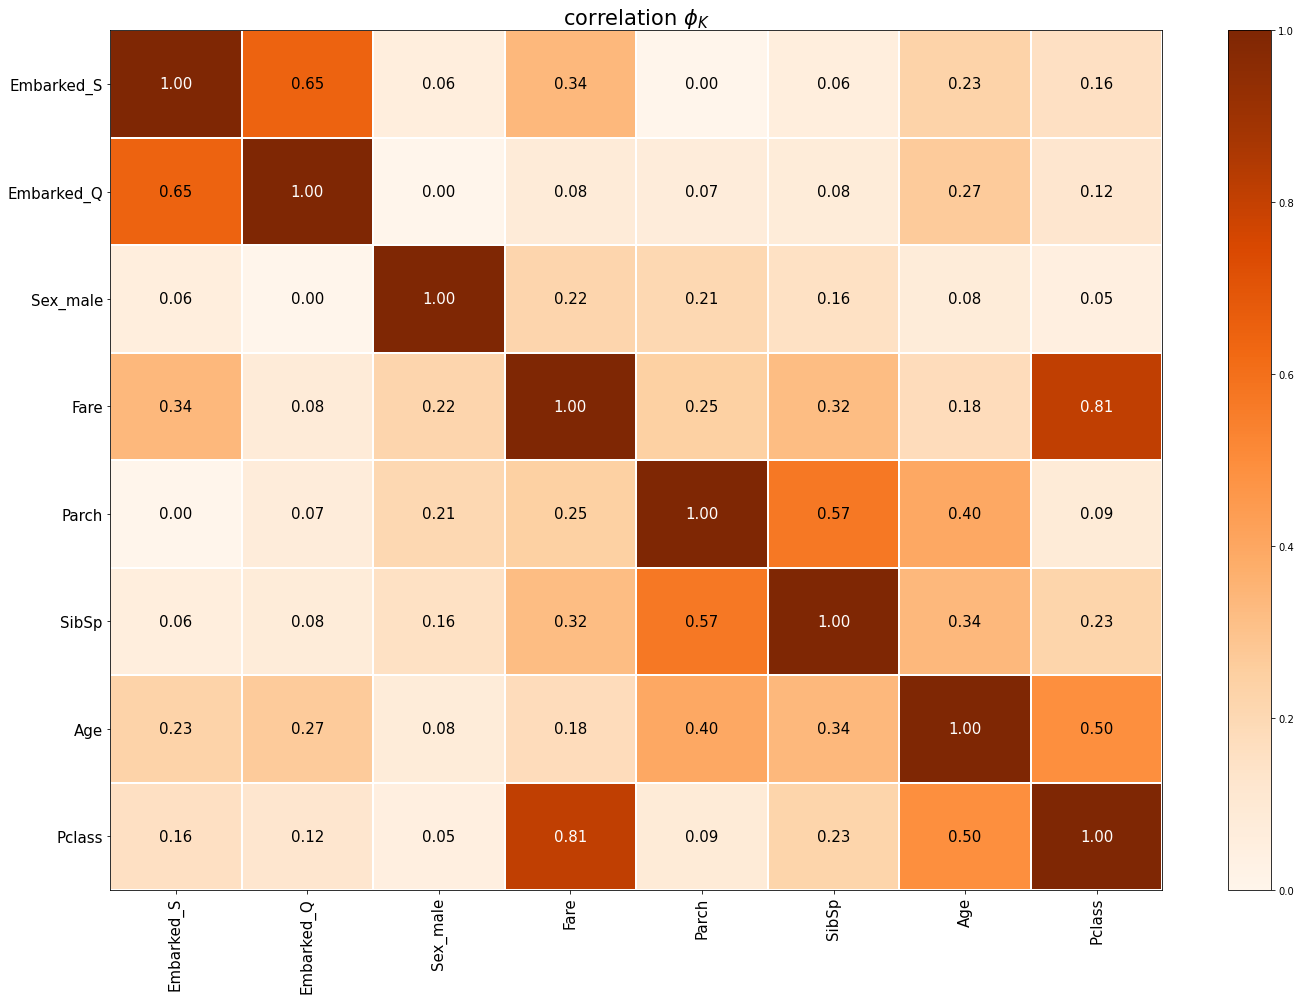

In [117]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Oranges", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                            figsize=(20, 14))
plt.tight_layout()

Как и ранее, сильной корреляции не выявлено. 

## Масштабирование признаков

Нормируем отдельео разбитую на train/valid выборки и отдельно  исходные features

In [118]:
numeric = set(col_cols) - set(['Survived'])

In [119]:
numeric = list(numeric)
numeric

['Pclass', 'Age', 'Parch', 'SibSp', 'Fare']

In [120]:
scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_valid[numeric] = scaler.transform(X_valid[numeric])
X_valid

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
151,-1.448638,-0.629231,0.471957,-0.499763,0.602676,0,0,1
100,0.893358,-0.412234,-0.513274,-0.499763,-0.510632,0,0,1
268,-1.448638,0.672747,-0.513274,0.682883,2.249997,0,0,1
538,0.893358,2.191720,-0.513274,-0.499763,-0.385386,1,0,1
263,-1.448638,0.021758,-0.513274,-0.499763,-0.660374,1,0,1
...,...,...,...,...,...,...,...,...
20,-0.277640,-0.159072,-0.513274,-0.499763,-0.167291,1,0,1
491,0.893358,-0.665397,-0.513274,-0.499763,-0.522880,1,0,1
307,-1.448638,-0.810061,0.471957,-0.499763,1.404883,0,0,0
206,0.893358,-0.267570,0.471957,-0.499763,-0.359783,1,0,1


## Вывод

1. Было произведено разделение на трейн и валид в отношении 1 к 4, и еще тестовая выборка у нас дана отдельно. 
2. Взаимной коррреляции найдено не было
3. Произведено масштабирование числовых признаков.

# Обучение

## Обучение без подбора гиперпараметров

### Логистическая регрессия

In [121]:
lr =  LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [122]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lr.predict(X)
  
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1_score(y, pred):.3f}')     
  print(f'ROC_AUC {label}={roc_auc_score(y, lr.predict_proba(X)[:, 1]):.3f}\n')     



Acc train=0.792
F1 train=0.731
ROC_AUC train=0.837

Acc test=0.768
F1 test=0.700
ROC_AUC test=0.817



### Метод ближайших соседей

In [123]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [124]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = knn.predict(X)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')
  print(f'F1 {label}={f1_score(y, pred):.3f}')  
  print(f'ROC_AUC {label}={roc_auc_score(y, knn.predict_proba(X)[:, 1]):.3f}\n') 

Acc train=0.832
F1 train=0.785
ROC_AUC train=0.903

Acc test=0.735
F1 test=0.677
ROC_AUC test=0.803



## Обучение с подбором гиперпараметров

### Логистическая регрессия

In [125]:
params = dict(
    C = [100, 10, 1, 0.1, 0.01, 0.001],
    penalty=['l1', 'l2', 'elasticnet'],
    solver=['saga'],
    multi_class =['auto', 'ovr', 'multinomial'],
    l1_ratio=[1]
)

In [126]:
lr = LogisticRegression()
cv = RandomizedSearchCV(lr, params, n_jobs=-1, cv=5)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                   param_distributions={'C': [100, 10, 1, 0.1, 0.01, 0.001],
                                        'l1_ratio': [1],
                                        'multi_class': ['auto', 'ovr',
                                                        'multinomial'],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['saga']})

In [127]:
best_params = cv.best_params_
best_params

{'solver': 'saga',
 'penalty': 'elasticnet',
 'multi_class': 'ovr',
 'l1_ratio': 1,
 'C': 1}

In [128]:
lr = LogisticRegression(**best_params)
lr.fit(X_train, y_train)

LogisticRegression(C=1, l1_ratio=1, multi_class='ovr', penalty='elasticnet',
                   solver='saga')

In [129]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = lr.predict(X)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')  
  print(f'F1 {label}={f1_score(y, pred):.3f}')   
  print(f'ROC_AUC {label}={roc_auc_score(y, lr.predict_proba(X)[:, 1]):.3f}\n') 

Acc train=0.789
F1 train=0.728
ROC_AUC train=0.836

Acc test=0.768
F1 test=0.700
ROC_AUC test=0.817



### Метод KNN

In [130]:
params = dict(
    n_neighbors = range(1, 40),
    weights = ['uniform', 'distance'],
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'],
    p=[1, 2]

)

In [131]:
knn = KNeighborsClassifier()
cv = RandomizedSearchCV(knn, params, n_jobs=-1, cv=5)
cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': range(1, 40),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']})

In [132]:
best_params = cv.best_params_
best_params

{'weights': 'uniform', 'p': 1, 'n_neighbors': 8, 'algorithm': 'kd_tree'}

In [133]:
knn = KNeighborsClassifier(**best_params)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=8, p=1)

In [134]:
for X, y, label in zip([X_train, X_valid], [y_train, y_valid], ['train', 'test']):
  pred = knn.predict(X)
  
  print(f'Acc {label}={accuracy_score(y, pred):.3f}')
  print(f'F1 {label}={f1_score(y, pred):.3f}') 
  print(f'ROC_AUC {label}={roc_auc_score(y, knn.predict_proba(X)[:, 1]):.3f}\n')    

Acc train=0.815
F1 train=0.746
ROC_AUC train=0.887

Acc test=0.781
F1 test=0.702
ROC_AUC test=0.827



### CatBoost

In [135]:
%%time

!pip install catboost
from catboost import CatBoostClassifier


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
CPU times: user 79.4 ms, sys: 17.6 ms, total: 97 ms
Wall time: 7.12 s


In [136]:
cat_cols_boost = ['Sex',	'Embarked']

In [137]:
model = CatBoostClassifier(loss_function='Logloss', 
                               cat_features=cat_cols_boost,
                               eval_metric = 'Accuracy', #:hints=skip_train~false
                               verbose=False)

grid = {'learning_rate': np.linspace(0.01, 0.2, 10),
        'depth': [3, 6],
        'l2_leaf_reg': [2, 5],
        'n_estimators': [200, 300]}

randomized_search_result = model.randomized_search(grid,
                                       X=X_train_cat, 
                                       y=y_train_cat,
                                       stratified = True,
                                       train_size = 0.8,
                                       cv=3,
                                       refit=True,
                                       verbose=500,
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7903225806
bestIteration = 35

0:	loss: 0.7903226	best: 0.7903226 (0)	total: 734ms	remaining: 6.6s

bestTest = 0.7983870968
bestIteration = 200


bestTest = 0.7983870968
bestIteration = 180


bestTest = 0.7983870968
bestIteration = 108


bestTest = 0.7741935484
bestIteration = 22


bestTest = 0.7903225806
bestIteration = 86


bestTest = 0.8064516129
bestIteration = 179


bestTest = 0.7903225806
bestIteration = 171


bestTest = 0.8064516129
bestIteration = 288


bestTest = 0.814516129
bestIteration = 76

9:	loss: 0.8145161	best: 0.8145161 (9)	total: 10.7s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.7874396135
bestIteration = 37

Training on fold [1/3]

bestTest = 0.7922705314
bestIteration = 74

Training on fold [2/3]

bestTest = 0.8009708738
bestIteration = 3



In [138]:
randomized_search_result['params']

{'depth': 6,
 'l2_leaf_reg': 5,
 'iterations': 300,
 'learning_rate': 0.1577777777777778}

In [139]:
best_model = CatBoostClassifier(depth = randomized_search_result['params']['depth'],
                                l2_leaf_reg = randomized_search_result['params']['l2_leaf_reg'], 
                                learning_rate = randomized_search_result['params']['learning_rate'],
                                eval_metric='Accuracy',
                                iterations=200,
                                loss_function= 'Logloss',
                                cat_features=cat_cols_boost,
                                random_seed=12345,
                                verbose=200)
    
best_model.fit(X_train_cat, y_train_cat)

pred_train = best_model.predict(X_valid_cat)
accuracy_score(y_valid_cat, pred_train)

0:	learn: 0.7774194	total: 3.99ms	remaining: 793ms
199:	learn: 0.9629032	total: 1.05s	remaining: 0us


0.7870967741935484

## Вывод

Видим, что с подбором гиперпараметров метрики незначительно повысислись. 
Accuracy достигает более менее нормальных значений: 0.755 на валидационной выборке у логистичекой регрессии и 0.781 у KNN.

# Проверка на тестовой выборке

In [197]:
df_test = pd.read_csv('/content/drive/MyDrive/1T_sprint_titanic/test.csv')

## Удаление избыточных признаков

In [198]:
df_test = df_test.drop(columns=['PassengerId','Name', 'Ticket', 'Cabin'])
df_test.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked'], dtype='object')

In [199]:
df_test = df_test[df_test['Embarked'].isna() == False]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 26.1+ KB


Остались пропуски в столбце возраста. И пропусков довольно много. Попробуем что-то с этим сделать. 

## Пропуски в AGE

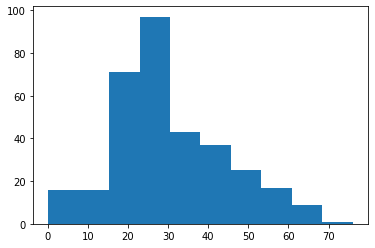

In [200]:
plt.hist(df_test['Age'])
plt.show()

Заменим пропуски в столбце Age на 100.

In [201]:
df_test["Age"] = df_test["Age"].fillna(100)

In [202]:
df_test["Age"] = df_test['Age'].transform(lambda x: x.round()).astype('int16')

In [203]:
df_test = df_test[df_test['Age'].isna() == False]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int16  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int16(1), int64(3), object(2)
memory usage: 23.7+ KB


## Замена пропуска в Fare

In [204]:
df_test[152:153]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,3,male,60,0,0,NaN,S


In [205]:
df_test.loc[df_test[df_test['Fare'].isna() == True].index, 'Fare'] = 50

In [206]:
df_test = df_test[df_test['Fare'].isna() == False]
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int16  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int16(1), int64(3), object(2)
memory usage: 23.7+ KB


## Удаление дубликатов

Дубликаты удалять не будем, так как конечный файл загрузки в соревнование должен содержать 418 записей

In [207]:

#df_test= df_test.drop_duplicates()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       418 non-null    int16  
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      418 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(1), int16(1), int64(3), object(2)
memory usage: 23.7+ KB


## Кодирование категориальных признаков

Произведем кодирование категориальных признаков.  Также как в обучающей выборке, создадим копию для CatBoost.

In [208]:
df_test_catboost = df_test.copy()
df_test_catboost.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34,0,0,7.8292,Q
1,3,female,47,1,0,7.0000,S
2,2,male,62,0,0,9.6875,Q
3,3,male,27,0,0,8.6625,S
4,3,female,22,1,1,12.2875,S


In [209]:
df_test = pd.get_dummies(df_test,drop_first=True)
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,3,34,0,0,7.8292,1,1,0
1,3,47,1,0,7.0000,0,0,1
2,2,62,0,0,9.6875,1,1,0
3,3,27,0,0,8.6625,1,0,1
4,3,22,1,1,12.2875,0,0,1


## Масштабирование признаков

In [210]:
df_test[numeric] = scaler.transform(df_test[numeric])
df_test.sample(7)

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
272,-1.448638,-0.484567,0.471957,-0.499763,1.933604,0,0,0
12,-1.448638,-0.593065,0.471957,-0.499763,0.899790,0,0,1
310,0.893358,-0.773895,-0.513274,-0.499763,-0.496092,1,0,1
182,-1.448638,-0.773895,0.471957,-0.499763,0.346652,0,0,1
353,-0.277640,0.347252,0.471957,1.865529,0.572332,1,0,1
26,-1.448638,-0.629231,-0.513274,0.682883,0.515044,0,0,0
91,0.893358,2.191720,-0.513274,-0.499763,-0.512923,1,0,1


## Вывод

Наши тестовые данные готовы для получения скора

# Получение предсказаний

In [211]:
submission = pd.read_csv('/content/drive/MyDrive/1T_sprint_titanic/gender_submission.csv', index_col = 0)
submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Survived  418 non-null    int64
dtypes: int64(1)
memory usage: 6.5 KB


## Предсказания для лучшей модели LR

In [212]:
submission['Survived'] = lr.predict(df_test)
submission.to_csv('my_submission_lr.csv')

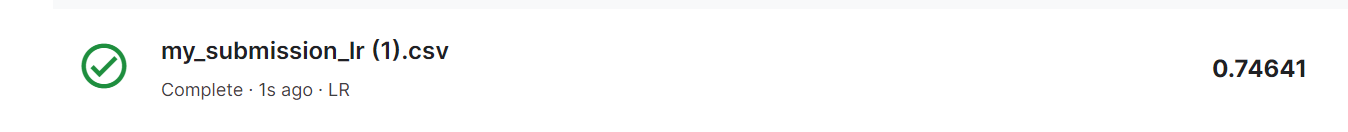

## Предсказания для лучшей модели KNN

In [213]:
submission['Survived'] = knn.predict(df_test)
submission.to_csv('my_submission_knn.csv')

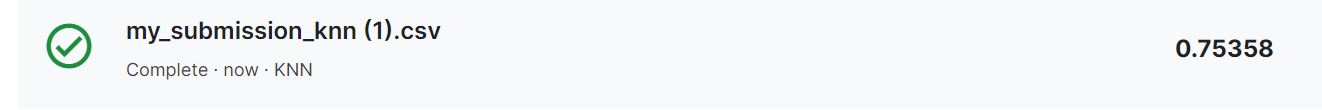

## Предсказания для лучшей модели CatBoost

In [214]:
submission['Survived'] = best_model.predict(df_test_catboost)
submission.to_csv('my_submission_catboost.csv')


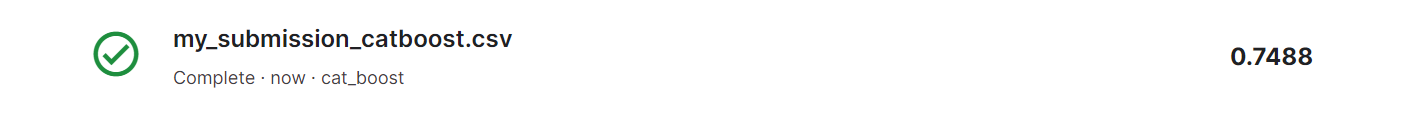

# Вывод

Как можно видеть, такая "тяжелая" модель, как CatBoost не дала прироста в скоре по сравнению с простыми моделями. Думаю, что датасет слишком прост для использования бустинга.

Конечно, можно было бы сделать более хорошую предобработку данных. Так как данных мало и каждый пассажир в целом может иметь значение. 

Лучший скор показала модель KNN с подбором гиперпараметров. Accuracy = 0.753 на тестовой выборке.